# VRP Demo with SCIP
This file is intended to build the model for the CVRP using SCIP

In [55]:
from pyscipopt import Model, Pricer, SCIP_RESULT, SCIP_STAGE
import networkx as nx
import random
import matplotlib.pyplot as plt

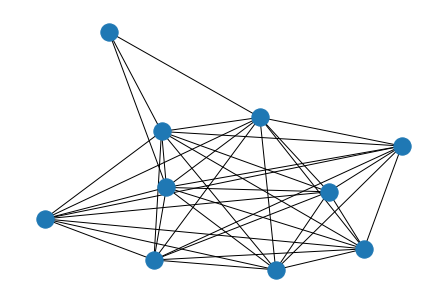

In [98]:
# Create Graph
G = nx.complete_graph(10)
for (u, v) in G.edges():
    G.edges[u,v]['weight'] = random.randint(1,10)

for i in range(1,7):
    G.remove_edge(i,8)
    # G.remove_edge(0,9)
# TODO: Import Graph here
nx.draw(G)

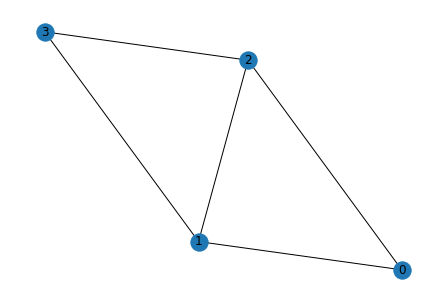

In [92]:
# Create Simple Graph for correctnes
G = nx.complete_graph(4)
G.remove_edge(0,3)
for (u, v) in G.edges():
    G.edges[u,v]['weight'] = 1
G.edges[1,2]['weight'] = 3
nx.draw(G,with_labels=True)

In [3]:
class VRP(Model):
    def __init__(self,graph):
        super().__init__()
        
        self.original_graph = graph
        self.graph = graph.copy()
        self.vars = {}
        self.cons = []

In [79]:
class VRPPricer(Pricer): 
    def pricerinit(self):
        self.data = {}
        self.data['cons'] = [self.model.getTransformedCons(con) for con in self.model.cons]
        self.data['vars'] = {path:self.model.getTransformedVar(var) for (path,var) in self.model.vars.items()}
    
    def pricerfarkas(self):
        print("Farkas Pricing has been called.")
        return {'result':SCIP_RESULT.SUCCESS}

    def pricerredcost(self):
        pi = [self.model.getDualsolLinear(con) for con in self.data['cons']]
        
        for path in nx.all_simple_paths(self.model.graph,0,list(G.nodes())[-1]):
            if tuple(path) not in self.data['vars'].keys():
                weight = nx.path_weight(self.model.graph,path,"weight")
                for node in path[1:-1]:
                    weight -= pi[node-1]
                if weight < 0:
                    var = self.model.addVar(vtype="B",obj=nx.path_weight(self.model.graph,path,"weight"),pricedVar=True)
                    for node in path[1:-1]:
                        self.model.addConsCoeff(self.data['cons'][node-1], var ,1)
       
                    self.data['vars'][tuple(path)] = var
#                     print(f"Found path {path} with negative reduced cost")
                    return {'result':SCIP_RESULT.SUCCESS}
        return {'result':SCIP_RESULT.SUCCESS}

In [99]:
model = VRP(G)
# Create a first valid variable
path = tuple(range(G.number_of_nodes()))
cost = nx.path_weight(G,path,"weight")
var = model.addVar(vtype="B",obj=cost)
print(f"Initial cost is {cost}")
model.vars[path] = var

pricer = VRPPricer()
model.includePricer(pricer, "pricer","does pricing")

# Only partitioning constraints for the first draft
for node in list(G.nodes())[1:-1]:
    cons = model.addCons(var == 1, name=str(node),modifiable=True)
    model.cons.append(cons)
    
# model.hideOutput()
model.optimize()
model.printBestSol()
print(pricer.data['vars'])

Initial cost is 52
feasible solution found by trivial heuristic after 0.0 seconds, objective value 5.200000e+01
presolving:
   (0.0s) probing cycle finished: starting next cycle
presolving (1 rounds: 1 fast, 1 medium, 1 exhaustive):
 0 deleted vars, 0 deleted constraints, 0 added constraints, 0 tightened bounds, 0 added holes, 0 changed sides, 0 changed coefficients
 0 implications, 0 cliques
presolved problem has 1 variables (1 bin, 0 int, 0 impl, 0 cont) and 8 constraints
      8 constraints of type <linear>
Presolving Time: 0.00
transformed 1/1 original solutions to the transformed problem space

 time | node  | left  |LP iter|LP it/n|mem/heur|mdpt |vars |cons |rows |cuts |sepa|confs|strbr|  dualbound   | primalbound  |  gap   | compl. 
  0.0s|     1 |     0 |     2 |     - |   584k |   0 |   2 |   8 |   8 |   0 |  0 |   0 |   0 |      --      | 5.200000e+01 |    Inf | unknown
r 0.0s|     1 |     0 |     6 |     - |simplero|   0 |   6 |   8 |   8 |   0 |  0 |   0 |   0 |      --    